# NBA Fantasy Stat Category League Analysis

## Introduction
The objective of this project is to figure out what basketball stat categories (if any) have the strongest correlation with performing well in **my specific** NBA Fantasy League. Assuming there are stat categories that do correlate, I will build a strategy around those stat categories in the future to try to do as well as I can in my league.

## Background
It is important to understand how the NBA fantasy league works to understand what I am trying to accomplish. 

Every year, 8-10 teams compete against each other to try to win the most matchups. Every week, your team will be matched up against one of the other teams. There will be 4-5 **separate** matchups every week (depening on the total amount of teams in the league)

Each *fantasy* team is made up of 15 NBA players who we select before the season begins. When those NBA players play *real* games and record *real* stats (e.g. a player scores 15 points and has 7 rebounds in a *real* NBA game), those stats get added to whoever's *fantasy* team "owns" that player. For this league we record 9 different stat categories: FG%, FT%, PTS, REB, AST, 3PM, STL, BLK, TO. (You don't need to know exactly what these categories mean.)

Each week, your matchup is scored based on whoever is winning more of those categories. See the example below:
| Stat Category | Team 1 | Team 2 | Category Winner |
|----------|------------|------------|----------|
| FG% | 0.512  | 0.480    | Team 1  |
| FT% | 0.850  | 0.777    | Team 1  |
| PTS | 950  | 1021    | Team 2  |
| REB | 249  | 201    | Team 1  |
| AST | 182  | 185    | Team 2  |
| 3PM | 87  | 75    | Team 1  |
| STL | 32  | 29    | Team 2  |
| BLK | 30  | 28    | Team 1  |
| TO (fewer is better)| 100  | 86    | Team 2  |

In the example above, Team 1 has won the matchup 6-3 as they scored better in 6 categories compared to Team 2 which only scored better in 3 categories. While the score is 6-3, this only counts as a single matchup win for Team 1.

## Data
My league has been active since the Fall of 2018 (this year is our 7th season), and some years have been hosted on ESPN whereas others have been hosted on Yahoo! 

Because of this and the fact that I would like to do further analysis (beyond this project) on my league, I have created my own custom python library of objects and methods to query, clean, and store data from every year we've played across the two different host sites. 

I won't go into this as it is an entire project in itself, but I used some existing libraries and modified them to minimize querying speeds/request counts as well as created my own methods and data structures to calculate "advanced" metrics for my league.

Within the objects, I store data on:
- **Each team's stats for every matchup**
- **Matchup Results (win/loss)**
- **Matchup Season and Week**

Using this data, I am able to calculate many other metrics around those stats.

In [27]:
!pip3 install gspread
!pip3 install stringcase
!pip3 install yahoo_oauth
from constants import*
from League import*

The libraries and imports above are needed for my libraries to collect and store the data

## Analysis
The first thing I want to look at is how different stat categories correlate with a team's **Matchup Win Percentage** over the course of a season. League standings are based on the **Matchup Win Percentage**, so the higher a team's is, the better their final standing will be.

One of the advanced metrics that I have calculated is the **Stat Category Ranking**. Typical values for each stat category are very different from each other, so I needed a way to normalize each team's performance within those categories. 

To do this, I take a specific stat category, find which teams had the min and max totals for it for the season, and assign the best total a 1 and the worst total a [league team count]. I then normalize all other teams' totals based on the min and max range. I chose the 1 to [league team count] scale as it was the easiest scale to communicate to other members of the leauge, e.g. a ranking of 1 meant you were 1st place in a category and 10 meant you were 10th place in a category. If your ranking was 4.2, you were proportionally around 4th place in a category. It is essentially a weighted rank.

$Stat Category Ranking = \frac{Max Stat Value-TeamStatValue}{MaxStatValue-MinStatValue}$

In [13]:
# import the following libraries to help visualize/plot data
!pip3 install matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as axs
from Models.League import *
from constants import *

In [15]:
# initialize custom fantasyLeague object
league = fantasyLeague()

initializing League Season: 2019
initializing League Season: 2020
initializing League Season: 2021
initializing League Season: 2022
initializing League Season: 2023
initializing League Season: 2024
initializing League Season: 2025
Access token refreshed successfully.
Fantasy League Initialized


Let's check to see if there's any correlation between the Stat Category Rankings and Matchup Win Percentage

### Figure 1: Correlation Coefficients of *Stat Category Ranking* and *Matchup Win Percentage (WL Win%)*

In [19]:
season_cat_rankings = {cat:[] for cat in mainCats}
season_winP = []

xlab = 'Category Rankings'
ylab = 'WL Win%'

for team in league.historicalMembers:
    for year in team.regSeasons:
        team_season = team.regSeasons[year]
        try:
            for cat in mainCats:
                season_cat_rankings[cat].append(team_season.get_team_avg_cat_ratings()[cat])
            season_winP.append(team_season.get_team_record_WL(format='p'))
        except ZeroDivisionError:
            pass

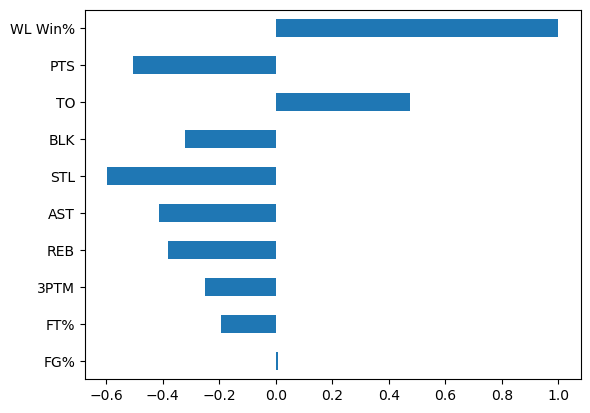

In [23]:
import pandas as pd
import numpy as np

df = pd.DataFrame(season_cat_rankings)
df[ylab] = season_winP
corrMat = df.corr()
corrMat.loc[ylab].plot(kind='barh')
plt.show()

Because the **Stat Category Rankings** are done on a scale from 10 to 1 where 1 is the best possible ranking, **the negative correlation values** in the plot above indicate that a better ranking in that stat category is **positively correlated** with winning your matchup. 

From the correlation study above, we can see that a high STL ranking (lower number) has a positive correlation with winning matchups. PTS and AST seem to also show a mild positive correlation. We also see that a high TO ranking has a negative correlation with winning matchups.

Let's plot the data to see if we can learn anything else about these correlations:

### Figure 2: *Stat Category Ranking* vs. *Matchup Win Percentage (WL Win%)*

<Figure size 640x480 with 0 Axes>

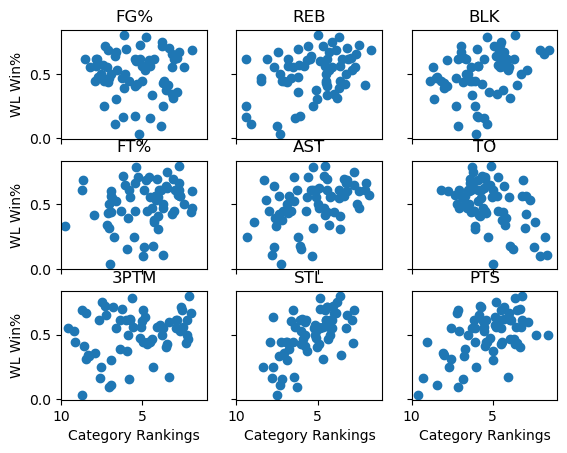

In [26]:
f = plt.figure()
f, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
x, y = 0, 0
for cat in season_cat_rankings:
    if x == 3:
        x = 0
        y += 1
    axes[x][y].scatter(season_cat_rankings[cat], season_winP)
    axes[x][y].set_title(cat)
    axes[x][y].set_xlim(10, 1)
    x += 1
for ax in axes.flat:
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.label_outer()
plt.show()

*Note that Category Rankings are plotted from 10 to 1 as **10 is the lowest ranking possible** (in our 10 team league)*

From the plots above, we can confirm some of what we saw in the correlation study. STL, PTS, and AST seem to have a positive linear relationship with the STL data having the least variation/showing the strongest positive signal. TO rankings clearly has a negative relationship with winning matchups.

This is interesting data, but it would be good to further contextualize it. While Matchup Win% is ultimately how the league standings are determined, it doesn't take into account how much you are winning by. For example, if you win a matchup 5-4, it registers equally as if you win that matchup 9-0, but clearly winning 9-0 would indicate a better overall performance during that matchup.

Let's instead look at the correlation between *Stat Category Ranking* and *Stat Category Win Percentage (Category Win%)*:
### Figure 3: Correlation Coefficients of *Stat Category Ranking* and *Stat Category Win Percentage*

In [32]:
season_cat_rankings = {cat:[] for cat in mainCats}
season_winP_Cats = []

xlab = 'Category Rankings'
ylab = 'Category Win%'

for team in league.historicalMembers:
    for year in team.regSeasons:
        team_season = team.regSeasons[year]
        try:
            for cat in mainCats:
                season_cat_rankings[cat].append(team_season.get_team_avg_cat_ratings()[cat])
            season_winP_Cats.append(team_season.get_team_record_Cats(format='p'))
        except ZeroDivisionError:
            pass

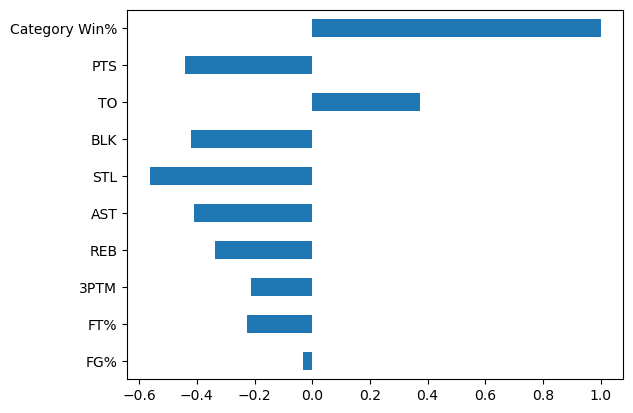

In [34]:
df = pd.DataFrame(season_cat_rankings)
df[ylab] = season_winP_Cats
corrMat = df.corr()
corrMat.loc[ylab].plot(kind='barh')
plt.show()

The **STL ranking still has the strongest correlation to Category Win%**, but it looks like the negative correlation between TO and Win% has decreased in magnitude. The magnitude of correlation between PTS and Win% has also decreased while the correlation between BLK and Win% has increased.

Again, let's plot this data to see if there's anything else we can learn from that:

### Figure 4: *Stat Category Ranking* vs. *Stat Category Win Percentage*

<Figure size 640x480 with 0 Axes>

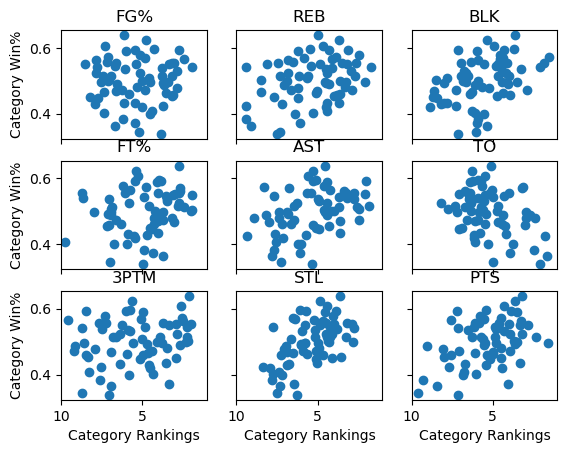

In [36]:
f = plt.figure()
f, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
x, y = 0, 0

for cat in season_cat_rankings:
    if x == 3:
        x = 0
        y += 1
    axes[x][y].scatter(season_cat_rankings[cat], season_winP_Cats)
    axes[x][y].set_title(cat)
    axes[x][y].set_xlim(10, 1)
    x += 1
    
for ax in axes.flat:
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.label_outer()
plt.show()

The plot above shows somewhat similar results to Figure 1. We still see that there is a somewhat linear relationship between STL, TO, and Category Win%. While the clusters for the other stat categories suggest a mild correlation, there is definitely more variation in these plots compared to the matchup win% plots.

In the **real** NBA, different players may specialize in different stat categories, but they are all still getting stats in all of these categories. I'm curious to see if there are **individual stat categories that correlate with each other**, and if so, will it be easy to prioritize STL, AST, BLK, and PTS by just **prioritizing 1-2 of them**? (e.g. If I prioritize performing well in STL and AST, will I be likely to also perform well in BLK and PTS?)

### Figure 5: Correlation Matrix of Stat Categories

In [40]:
!pip3 install seaborn
import seaborn as sns

<Axes: >

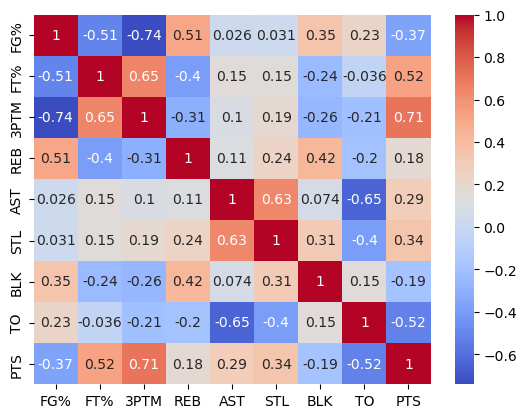

In [42]:
df = pd.DataFrame(season_cat_rankings)
corrMat = df.corr()
sns.heatmap(corrMat, annot=True, cmap='coolwarm')

From this correlation matrix, we can see that **AST and STL have a correlation with each other**, which bodes well for my strategy as it would suggest that if I prioritize one of those stat categories, I am somewhat likely to do well in the other, and both of them have a correlation with Category Win%.

**PTS have a strong correlation with 3PM** (which makes sense given the increasing rate of 3-pointers in today's NBA). Even though 3PM doesn't have a strong correlation with either Win Percentages, it probably wouldn't hurt to do well in that category while also doing well in PTS

Lastly, we see that **TO has a mild negative correlation with AST and PTS**, which suggests that if we prioritize AST and PTS, we are likely to perform poorly in TO. This shouldn't be that big of an issue considering performing badly in TO correlates well with winning matchups.

### Strategy Limitation
Overall, prioritizing these 4 stat categories seems like a good strategy, but there are still limitations to it. Both Win Percentages only take into account a team's relative performance against a single opponent that specific week as opposed to how well they actually performed relative to every other team in the league.

I developed another metric--the *Season Team Ranking*--to measure how well a team performed relative to other team's in the league over the course of a season. It takes the average of all the team's *Season Stat Category Rankings*, and then re-scales it to a 10-1 scale based on the range of averages (similar to how the *Stat Category Rankings* were calculated).

$Season Ranking = \frac{Max Avg Ranking - Team Avg Ranking}{Max Avg Ranking - Min Avg Ranking}$

### Figure 6: Correlation Coefficients of *Stat Category Ranking* and *Season Team Ranking*

In [46]:
season_team_rankings = []
season_cat_rankings = {cat: [] for cat in mainCats}

for team in league.historicalMembers:
    for year in team.regSeasons:
        team_season = team.regSeasons[year]
        try:
            for cat in mainCats:
                season_cat_rankings[cat].append(team_season.get_team_avg_cat_ratings()[cat])
            season_team_rankings.append(team_season.get_team_avg_rating())
        except ZeroDivisionError:
            pass

xlab = 'Season Category Rankings'
ylab = 'Season Team Rankings'

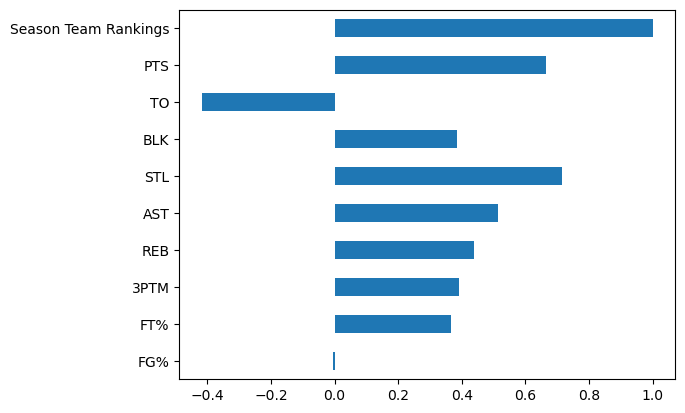

In [48]:
df = pd.DataFrame(season_cat_rankings)
df[ylab] = season_team_rankings
corrMat = df.corr()
corrMat.loc[ylab].plot(kind='barh')
plt.show()

We can see in this correlation study that the same stat categories are showing strong correlations. We even see slightly higher magnitudes of correlations for some of those stat categories.

Let's plot the data to see if there's anything there:

### Figure 7: *Stat Category Ranking* vs. *Season Team Ranking*

<Figure size 640x480 with 0 Axes>

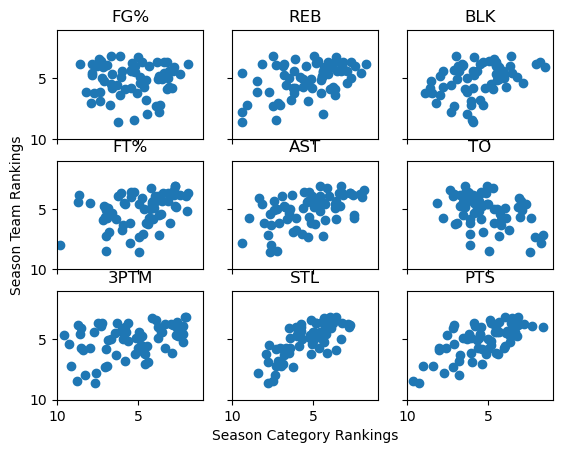

In [50]:
f = plt.figure()
f, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
x, y = 0, 0
for cat in season_cat_rankings:
    if x == 3:
        x = 0
        y += 1
    axes[x][y].scatter(season_cat_rankings[cat], season_team_rankings)
    axes[x][y].set_title(cat)
    axes[x][y].set_xlim(10, 1)
    axes[x][y].set_ylim(10, 1)
    if x == 2 and y == 1:
        axes[x][y].set(xlabel = xlab)
    elif x == 1 and y == 0:
        axes[x][y].set(ylabel = ylab)
    x += 1

# for ax in axes.flat:
#     ax.set(xlabel=xlab, ylabel=ylab)
#     ax.label_outer()
plt.show()

We can already see in these plots that the data is more tightly clustered, and has less variation within it. You can see that there is a clearer linear relationship between STL and PTS rankings and the season team rankings. Also much clearer to see that TO ranking is negatively correlated with the season team rankings.

These plots defintiely make a case that certain stat categories should be prioritized over others when planning out how to build a fantasy team in this league. 

We can get more granular than this though. Instead of looking at average category rankings over the season and average season rankings, we can directly compare a team's category rankings in a week against their overall ranking for that same week (average of all category rankings that week).

This is useful as throughout the course of a season, a team's performance in certain stat categories will fluctuate with natural fluctuations in their **real** NBA players' performances or playing time as well as fantasy teams changing their strategy mid-season. Looking at it on a per-week basis will really tell us if week-to-week prioritizing certain stat categories is useful.

### Figure 8: Correlation Coefficients of *Stat Category Ranking* and *Season Team Ranking*

In [56]:
weekly_rankings = []
weekly_cat_rankings = {cat: [] for cat in mainCats}

xlab = 'Category Rankings'
ylab = 'Weekly Team Rankings'

for year in league.seasons:
    season = league.seasons[year]
    reg = season.regSsn
    for week in range(1, reg.currentWeek + 1):
        for team in season.teams:
            try:
                weekly_rankings.append(reg.get_week_rankings(week, sortedRetrun=False)[team])
                for cat in mainCats:
                    weekly_cat_rankings[cat].append(reg.get_week_cat_rankings(week)[team][cat])
            except (ZeroDivisionError, KeyError):
                pass

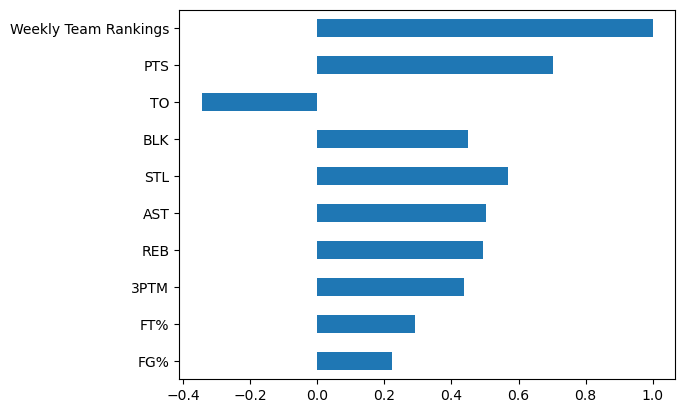

In [58]:
df = pd.DataFrame(weekly_cat_rankings)
df[ylab] = weekly_rankings
corrMat = df.corr()
corrMat.loc[ylab].plot(kind='barh')
plt.show()

The correlation study shows that PTS as the strong correlation (rigt around 0.7) to a team's ranking for a single week, with STL, AST, and REB also showing mild correlations. We also see that the negative correlation with TO ranking is not quite as strong anymore.

Let's plot the data to see if there's anything to be seen there.

### Figure 9: *Stat Category Ranking* vs. *Season Team Ranking*

<Figure size 12000x9000 with 0 Axes>

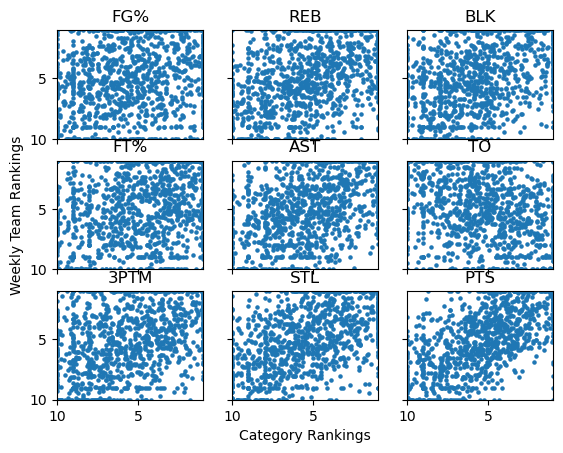

In [60]:
f = plt.figure(figsize=(120,90))
f, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

x, y = 0, 0
for cat in weekly_cat_rankings:
    if x == 3:
        x = 0
        y += 1
    axes[x][y].scatter(weekly_cat_rankings[cat], weekly_rankings, s=5)
    axes[x][y].set_title(cat)
    axes[x][y].set_xlim(10, 1)
    axes[x][y].set_ylim(10, 1)
    if x == 2 and y == 1:
        axes[x][y].set(xlabel = xlab)
    elif x == 1 and y == 0:
        axes[x][y].set(ylabel = ylab)
    x += 1

# for ax in axes.flat:
#     ax.set(xlabel=xlab, ylabel=ylab)
#     ax.label_outer()

plt.show()

It's clear to see that certain stat categories look to have a much more linear relationship with the weekly team rankings than others. PTS clearly shows the strongest, while STL and AST also have a somewhat tight cluster. Some of the other stat categories like FG% and FT% show a large amount of outliers, which tracks with the lower correlation coefficients we saw in Figure 8.

## Conclusion
After processing and analyzing all this data, it seems clear to me that going forward, I should prioritize building my fantasy team around players who are good at PTS and STL as these two categories consistently showed fairly strong correlations with all the different metrics for overall team performance.

## Limitations
Of course, there are still many limitations to these findings. 

As mentioned earlier, **real** NBA players' performances in all these stat categories fluctuate (a lot) throughout the course of a season, so just because your team performs well in these categories one week, there is no guarantee that the same will be the case in the next week with the same group of players.

The data that was collected was from fantasy teams that were making their best guess at what stat categories to prioritize (if any) with strategies often changing throughout the season. If some (or even all) teams were to start focusing on specific categories based on these findings, it could cannibalize the effect of some of these categories, causing other stat categories that previously seemed not valuable to become more valuable.

## Preliminary Results
Although this data contains the most up-to-date stats from the 2025 season, I started this analysis at the end of the 2024 season, and the conclusions remained largely the same. I adopted the strategy going into the 2025 season (prioritizing PTS and then STL) to build my team, and my team currently sits at the top of the standings with the highest Matchup Win % in the league. With that said, I do not have the best overall Team Ranking in the league (3rd best), so it is harder to say how effective the strategy has been.